In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Memory allocation

(Note that most of this chapter uses C syntax, and are largely applicable to C and C-like paradigms.
More modern languages do not allow for manual allocation of memory, but the principle still holds behind the scenes)

Memory is requested and allocated in contiguous blocks.
This is done using two functions:
* `malloc`:
    * finds a region of free memory, reserves it, and returns the address to it
* `free`:
    * sets a region of memory to be free
    
<span id="contiguous-memory"> Memory should be contiguous as it is much more convenient for processes to manage, compared to having account for "jumps" in the memory addresses. </span>

## Allocation size

Memory can be allocated using:
* Variable allocation size
    * allocates memory equals to the amount requested
* Fixed allocation size
    * allocates in fixed allocation units

## Fragmentation

As processes request and free memory, our memory segments becomes more **fragmented**.
This means some segments of memory becomes unusable.

### Internal fragmentation

* Memory is allocated but unused.
* Occurs under fixed allocation sizes
    * we allocated more memory than the process requested, hence leading to unused memory.

For example, a program requested for 1.8MB of memory, but because we allocate in blocks of 1MB, we gave the process 2MB instead, leading to 0.2MB of unused memory.

Consider the following sequence of memory request:

```
char* mem1 = malloc(40)
char* mem2 = malloc(10)
char* mem3 = malloc(10)
```

Suppose that we have 200B of memory, and we allocate in chunks of 100B.
Our memory would look like below:

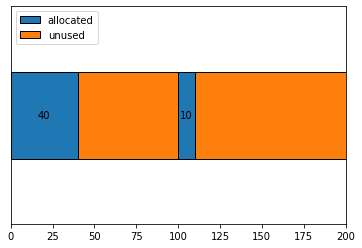

In [2]:
plt.barh(y=1, width=[40, 10], left=[0, 100], label="allocated", edgecolor="black")
plt.barh(y=1, width=[60, 90], left=[40, 110], label="unused", edgecolor="black")
plt.annotate("40", xy=(20, 1), ha="center", va="center")
plt.annotate("10", xy=(105, 1), ha="center", va="center")
plt.ylim(0, 2)
plt.xlim(0, 200)
plt.yticks([])
plt.legend(loc="upper left")
plt.show()

The last `malloc` will fail since we cannot allocate the requested memory.
Due to internal fragmentation, despite there being 150B worth of unused memory, we are unable to satisfy the request.

### External fragmentation

* Memory is unallocated and unused.
* More prominent in variable allocation sizes
* Occurs when processes frees allocated memory, leading to non-contiguous chunks of unused memory


Consider the following sequence of memory request:

```
char* mem1 = malloc(40)
char* mem2 = malloc(30)
char* mem3 = malloc(100)
free(mem2)
char* mem4 = malloc(40)
```

Suppose that we have 200B of memory.
Our memory would look like below.

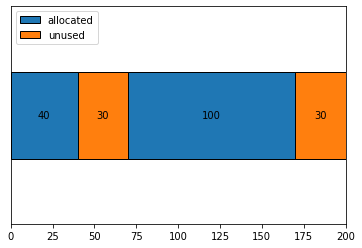

In [3]:
plt.barh(y=1, width=[40, 100], left=[0, 70], label="allocated", edgecolor="black")
plt.barh(y=1, width=[30, 30], left=[40, 170], label="unused", edgecolor="black")
plt.annotate("40", xy=(20, 1), ha="center", va="center")
plt.annotate("30", xy=(55, 1), ha="center", va="center")
plt.annotate("100", xy=(120, 1), ha="center", va="center")
plt.annotate("30", xy=(185, 1), ha="center", va="center")
plt.ylim(0, 2)
plt.xlim(0, 200)
plt.yticks([])
plt.legend(loc="upper left")
plt.show()

And the last allocation will fail once again, because we are unable to obtain a contiguous block of 40B.

## Memory management

For our system to know how much memory we have, and the addresses of the free memory, we need some system to track it.
There are a few paradigms for us to choose from.

Terminology:
* **hole**: a block of free memory
* **chunk**: a block of allocated memory

### Variable allocation size

#### Free list 

Addresses of free memory is kept in a [doubly-linked list](../data_structures/linked_list.ipynb#Doubly-linked-list).
Initially, the list is empty.
Once `free` is called, the link list will contain nodes which have the start and end addresses of each hole.

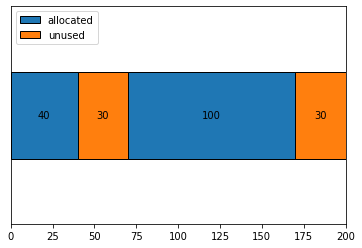

In [4]:
plt.barh(y=1, width=[40, 100], left=[0, 70], label="allocated", edgecolor="black")
plt.barh(y=1, width=[30, 30], left=[40, 170], label="unused", edgecolor="black")
plt.annotate("40", xy=(20, 1), ha="center", va="center")
plt.annotate("30", xy=(55, 1), ha="center", va="center")
plt.annotate("100", xy=(120, 1), ha="center", va="center")
plt.annotate("30", xy=(185, 1), ha="center", va="center")
plt.ylim(0, 2)
plt.xlim(0, 200)
plt.yticks([])
plt.legend(loc="upper left")
plt.show()

Reusing the previous example, the linked list would be:
```
{start:40, end:70} -> {start:170, end:200}
```

Since we are using linked list, it makes sense that we want to have as few holes as possible, so as it reduce the overhead from list traversal.
Also, fewer but bigger holes allows more freedom in memory allocation as we can satisfy larger `malloc`.

When memory is freed, we check if the freed memory can be combined with a previous hole to create a larger one.

For example, if `free(mem3)` is called, our resultant linked list would be:

Reusing the previous example, the linked list would be:
```
{start:40, end:200} 
```
instead of 
```
{start:40, end:70} -> {start:70, end:170} -> {start:170, end:200}
```

##### Allocation algorithm

Different allocation algorithm can lead to different performance.

###### Best fit

Pick the smallest hole that satisfy the request.

* Slower, as it has to search the entire list every time
* Tend to lead to smaller holes, thus more external fragmentation

###### First fit

Pick the first hole that satisfy the request.

* Much faster than best fit
* Same fragmentation issue as best fit

###### Next fit

Pick the first hole that satisfy the request, but start from where the previous search ended.

* In practice, faster than first fit
* Same fragmentation issue as best fit

##### Compaction

To combat external fragmentation, we perform **compaction**.
We simply move all the memory address to one end, leading to one big hole.

However, there is huge overhead in performing this process, and having to find and change all pointer addresses is rather difficult.

## Fixed size allocation

### Multiple free list

We use multiple free list to store our holes.
Each free list contains holes of size $2^k$ for $k \geq 0$.

Our initial memory size is $2^N$, and this is our initial large hole.

Once memory is requested, we find the largest hole that can satisfy the request.
If the hole is too big (at least twice the size of the request), then we split the hole into halves until it is an appropriate size.
After each division, the holes are added to the free list respective to their size.

**Once a hole is created, it cannot be merged.** 

(This is to maintain proper memory boundary, where we expect memory of size $2^k$ to start at $n2^k$ and end at $(n +1) 2^k$.
Merging may violate this constraint)

For example, if we start with memory of size 1MB.
Then we request for 200kB of memory.
The result is the following free lists.

```
512K: {start:0, end:512}
256K: {start:512, end:768}
```

And the memory is allocated at `769-1024`.

#### Buddy system

Not being able to merge holes can be rather detrimental as we may break down the memory into too many small holes and we are unable to allocate large chunks of memory.

To avoid this, we introduce a **buddy system**, so that we can merge holes while retaining proper memory boundaries.

In this system, whenever we break a hole into two, we pair them up as buddies.
Once a pair of buddies are freed, we can combine them into a large hole.

## Cautions

### Avoid leaking memory


If we request for memory, but lost the pointer to the address, the memory becomes allocated and unable to be used.
Repeated request will consume memory capacity.
This is called a **memory leak**.

An example would be the below:

``` c 
void f() {
    char *p;
    p = (char *) malloc(8 * sizeof(char))
    return
}

int main() {
    f();
}
```

The program calls `malloc`, but doesn't free the memory.
After the function exits, the pointer to the allocated memory is lost, prevent us from freeing it subsequently.
Hence, this is a memory leak.

### Avoid dangling pointers

**Dangling pointers** are pointers that points to freed memory.

An example would be the below:

``` c 
char* f() {
    char *p;
    p = (char *) malloc(8 * sizeof(char))
    free(p)
    return p
}

int main() {
    char* p = f();
}
```

Here, we allocated and freed `p`.
But we returned `p` out of the function.
This means `main` still can manipulate `p` even though the ownership of that memory chunk is relinquished.
Thus, `main` may access unexpected data, or modify the memory of another function.

Note that this can also happen rather subtly, as per below:

``` c 
char* f() {
    char p[8];
    return p
}

int main() {
    char* p = f();
}
```